**MDS7203 Modelos Generativos Profundos, Primavera 2023**

# Laboratorio 4: Modelos basados en *score*

**Profesor**: Felipe Tobar

**Auxiliares**: Cristóbal Alcázar, Camilo Carvajal Reyes.
**Ayudante**: Joaquín Barceló.  
**Nombre**: Arturo Lazcano

In [1]:
########### Imports ###########
import numpy as np
import math
import matplotlib.pyplot as plt
!pip install celluloid
from celluloid import Camera
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import time

# P1

## (a)

\begin{equation*}
p(x) = \sum_{k=1}^K \frac{\alpha_k}{\sqrt{(2\pi)^d \det{(\Sigma_k)}}} e^{-\frac{1}{2} (x-\mu_k)^T \Sigma_k^{-1} (x-\mu_k) }
\end{equation*}

La siguiente celda está en modo bloque pues despúes le agregaremos más métodos y ahí se definirá como código correctamente

```python
class GaussianMixture():

  def __init__(self, mu, sigma, alpha):
    self.mu = mu
    self.sigma = sigma
    self.alpha = alpha
    self.K = len(alpha)

  
  def p(self, x):
    d = len(x) if type(x)==np.ndarray else 1
    suma = 0
    
    # Ver dimensión del input y adecuar cálculos a eso

    if d>1:
      for k in range(self.K):
        frac = self.alpha[k] / (np.sqrt(2*np.pi)**d * np.linalg.det(self.sigma[k]))
        exp = np.exp(-1/2 * (x-self.mu[k]).T @ np.linalg.inv(self.sigma[k]) @ (x-self.mu[k]))
        suma += (frac*exp)

    else:
      for k in range(self.K):
        frac = self.alpha[k] / (np.sqrt(2*np.pi) * self.sigma[k])
        exp = np.exp(-1/2 * (x-self.mu[k]) * self.sigma[k] * (x-self.mu[k]))
        suma += (frac*exp)
    return suma

```

## (b)

\begin{align*}
\nabla_x \log  p(x) = \frac{1}{p(x)} \nabla_x p(x)  &= \frac{1}{\displaystyle \Bigg( \sum_{k=1}^K \frac{\alpha_k}{\sqrt{(2\pi)^d \det{(\Sigma_k)}}}\Bigg)} \cdot \frac{1}{e^{-\frac{1}{2} (x-\mu_k)^T \Sigma_k^{-1} (x-\mu_k)} } \cdot \nabla_x p(x)
\end{align*}

\begin{align*}
 \Longrightarrow \nabla_x \log  p(x) = \frac{1}{\displaystyle \Bigg( \sum_{k=1}^K \frac{\alpha_k}{\sqrt{(2\pi)^d \det{(\Sigma_k)}}} e^{-\frac{1}{2} (x-\mu_k)^T \Sigma_k^{-1} (x-\mu_k)}\Bigg)} \cdot \sum_{k=1}^K \frac{\alpha_k}{\sqrt{(2\pi)^d \det{(\Sigma_k)}}} e^{-\frac{1}{2} (x-\mu_k)^T \Sigma^{-1}(x-\mu_k)} \cdot (-\Sigma_k^{-1}(x-\mu_k))
\end{align*}

In [2]:
class GaussianMixture():
  '''
  Clase de Mixturas Gaussianas
  '''
  def __init__(self, mu, sigma, alpha):
    self.mu = mu
    self.sigma = sigma
    self.alpha = alpha
    self.K = len(alpha)


  # Densidad (pdf)
  def p(self, x):
    d = len(x) if type(x)==np.ndarray else 1
    suma = 0
    # Separar por dimensiones de x
    if d>1:
      for k in range(self.K):
        frac = self.alpha[k] / (np.sqrt(2*np.pi)**d * np.linalg.det(self.sigma[k]))
        exp = np.exp(-1/2 * (x-self.mu[k]).T @ np.linalg.inv(self.sigma[k]) @ (x-self.mu[k]))
        suma += (frac*exp)
    else:
      for k in range(self.K):
        frac = self.alpha[k] / (np.sqrt(2*np.pi) * self.sigma[k])
        exp = np.exp(-1/2 * (x-self.mu[k]) * self.sigma[k] * (x-self.mu[k]))
        suma += (frac*exp)
    return suma


  # Cálcular score
  def score(self, x):
    d = len(x) if type(x)==np.ndarray else 1
    derivada = 0
    # Separar por dimensiones
    if d>1:
      for k in range(self.K):
        frac = self.alpha[k] / (np.sqrt(2*np.pi)**d * np.linalg.det(self.sigma[k]))
        exp = np.exp(-1/2 * (x-self.mu[k]).T @ np.linalg.inv(self.sigma[k]) @ (x-self.mu[k]))
        cadena = -np.linalg.inv(self.sigma[k]) @ (x-self.mu[k])
        derivada += (frac*exp*cadena)
    else:
      for k in range(self.K):
        frac = self.alpha[k] / (np.sqrt(2*np.pi) * self.sigma[k])
        exp = np.exp(-1/2 * (x-self.mu[k]) * self.sigma[k] * (x-self.mu[k]))
        cadena = -self.sigma[k] * (x-self.mu[k])
        derivada += (frac*exp*cadena)

    return (1/self.p(x)) * derivada


  # Generar samples directamente de las Gaussianas (se suponen 3)
  def samples(self, N):
    samples = []
    for n in range(N):
      u = np.random.uniform(low=0.0, high=1.0, size=1)
      if u <= self.alpha[0]:
        s = np.random.multivariate_normal(mean=self.mu[0], cov=self.sigma[0], size=1)
      elif self.alpha[0] < u <= self.alpha[1] + self.alpha[0]:
        s = np.random.multivariate_normal(mean=self.mu[1], cov=self.sigma[1], size=1)
      else:
        s = np.random.multivariate_normal(mean=self.mu[2], cov=self.sigma[2], size=1)
      samples.append(s[0])
    return np.array(samples)

## (c)

A continuación se definen las lista de $\mu$, $\sigma$ y $\alpha$ a utilizar. Estos fueron los seleccionados finalmente tras probar varias de estas listas y analizar los gráficos y algoritmos que vienen.

In [3]:
# medias, covarianzas y pesos a utilizar
lista_mu = np.array([ [0,-6], [-10,8], [11,4] ])
lista_cov = np.array([ [[1, 0], [0, 1]], [[3, -3], [-3, 3.5]], [[3, -1], [-1, 0.5]] ])
lista_alpha = np.array([0.5, 0.3, 0.2])
lista_gaussianas = []

for i in range(3):
  lista_gaussianas.append(np.random.multivariate_normal(lista_mu[i], lista_cov[i], size=500))

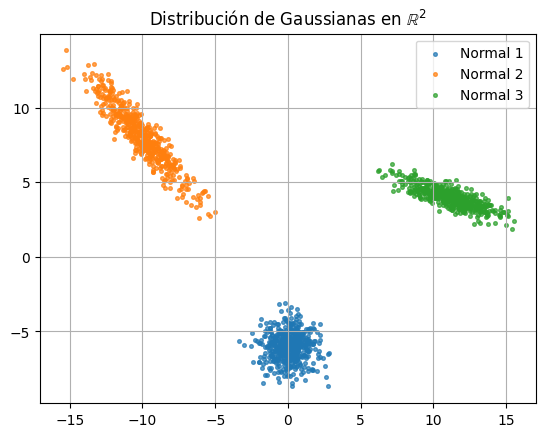

In [4]:
# Gráfico de Gaussianas originales
for i in range(3):
  plt.scatter(lista_gaussianas[i][:, 0], lista_gaussianas[i][:, 1],
              alpha=0.7, label=f'Normal {i+1}', s=7)
plt.title('Distribución de Gaussianas en $\mathbb{R}^2$')
plt.legend()
plt.grid()
plt.show()

In [5]:
# Instanciar modelo
gm = GaussianMixture(lista_mu, lista_cov, lista_alpha)

# Grilla
xy = np.mgrid[-15:15:0.5, -8:13:0.5].reshape(2, -1).T

In [6]:
# Calcular densidad y score
densidad = np.empty(len(xy))
score = np.empty((len(xy), 2))

for i in range(len(xy)):
  densidad[i] = gm.p(xy[i])
  score[i] = gm.score(xy[i])

In [7]:
# reshape para graficar
eje_x = np.reshape(xy[:,0], (60, 42))
eje_y = np.reshape(xy[:,1], (60, 42))
eje_z_p = np.reshape(densidad, (60, 42))
u = np.reshape(score[:,0], (60, 42))
v = np.reshape(score[:,1], (60, 42))

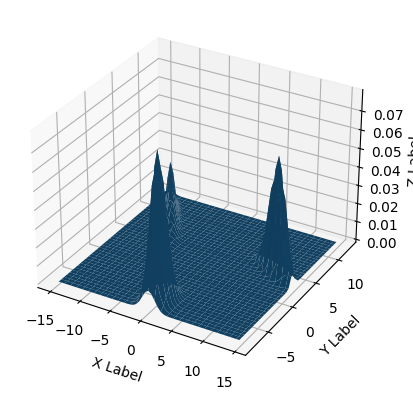

In [8]:
# Gráfico matplotib 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(eje_x, eje_y, eje_z_p)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [9]:
# Gráfico plotly 3d (se mueve así que es más bacan)
fig = go.Figure(data=[go.Surface(z=eje_z_p, x=eje_x, y=eje_y)])
fig.update_layout(title='Densidad Mixtura Gaussiana', autosize=False,
                  width=850, height=550)
fig.show()

Notar que en el gráfico de las densidadaes, tanto su media y matriz de covarianza junto con el valor de $\alpha$ pueden hacer variar estas densidades. Ya sea en altura como en la misma distribución del espacio.

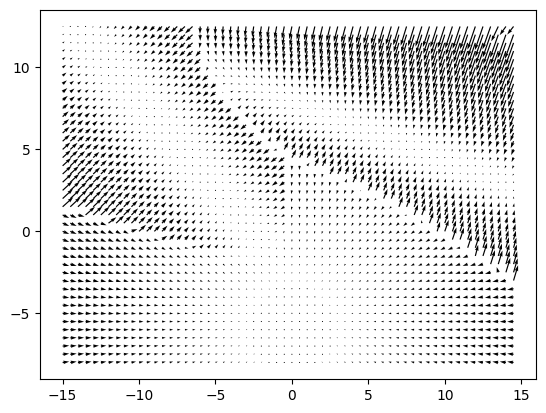

In [10]:
# Gráfico matplotlib de score
fig, ax = plt.subplots()
ax.quiver(eje_x, eje_y, u, v)
plt.show()

In [11]:
# Gráfico de score plotly
fig = ff.create_quiver(eje_x, eje_y, u, v)
fig.show()

Acá se muestran los gráficos que representan los scores de estos puntos. Este gráfico está conformado por flechas pues el score para un punto $x$ retorna un vector de dos dimensiones por lo que podemos interpretarlo como la dirección a la cual convergen los puntos al cabo de un tiempo $T$.  
Se puede ver también el los gráficos como las flechas tienden a apuntar, y así generar, a las densidades originales de las gaussianas. Es por lo anterior que se espera que el algoritmo funcione correctamente después de cierto tiempo $T$.

## (d)

In [12]:
class GaussianMixture():
  '''
  Clase de Mixturas Gaussianas
  '''
  def __init__(self, mu, sigma, alpha):
    self.mu = mu
    self.sigma = sigma
    self.alpha = alpha
    self.K = len(alpha)


  # Densidad (pdf)
  def p(self, x):
    d = len(x) if type(x)==np.ndarray else 1
    suma = 0
    # Separar por dimensiones de x
    if d>1:
      for k in range(self.K):
        frac = self.alpha[k] / (np.sqrt(2*np.pi)**d * np.linalg.det(self.sigma[k]))
        exp = np.exp(-1/2 * (x-self.mu[k]).T @ np.linalg.inv(self.sigma[k]) @ (x-self.mu[k]))
        suma += (frac*exp)
    else:
      for k in range(self.K):
        frac = self.alpha[k] / (np.sqrt(2*np.pi) * self.sigma[k])
        exp = np.exp(-1/2 * (x-self.mu[k]) * self.sigma[k] * (x-self.mu[k]))
        suma += (frac*exp)
    return suma


  # Cálcular score
  def score(self, x):
    d = len(x) if type(x)==np.ndarray else 1
    derivada = 0
    # Separar por dimensiones
    if d>1:
      for k in range(self.K):
        frac = self.alpha[k] / (np.sqrt(2*np.pi)**d * np.linalg.det(self.sigma[k]))
        exp = np.exp(-1/2 * (x-self.mu[k]).T @ np.linalg.inv(self.sigma[k]) @ (x-self.mu[k]))
        cadena = -np.linalg.inv(self.sigma[k]) @ (x-self.mu[k])
        derivada += (frac*exp*cadena)
    else:
      for k in range(self.K):
        frac = self.alpha[k] / (np.sqrt(2*np.pi) * self.sigma[k])
        exp = np.exp(-1/2 * (x-self.mu[k]) * self.sigma[k] * (x-self.mu[k]))
        cadena = -self.sigma[k] * (x-self.mu[k])
        derivada += (frac*exp*cadena)

    return (1/self.p(x)) * derivada


  # Generar samples directamente de las Gaussianas (se suponen 3)
  def samples(self, N):
    samples = []
    for n in range(N):
      u = np.random.uniform(low=0.0, high=1.0, size=1)
      if u <= self.alpha[0]:
        s = np.random.multivariate_normal(mean=self.mu[0], cov=self.sigma[0], size=1)
      elif self.alpha[0] < u <= self.alpha[1] + self.alpha[0]:
        s = np.random.multivariate_normal(mean=self.mu[1], cov=self.sigma[1], size=1)
      else:
        s = np.random.multivariate_normal(mean=self.mu[2], cov=self.sigma[2], size=1)
      samples.append(s[0])
    return np.array(samples)


  # Algoritmo de Langevin dynamics
  def langevin_dynamics(self, eps=0.05, T=75, n_points=200):
    x0 = np.random.uniform(low=xy[0], high=xy[-1], size=(n_points,2))  #prior
    trayectoria = [[x] for x in x0]
    camera = Camera(plt.figure())
    for t in range(T):
      # primer caso
      if t==0:
        x = x0
        plt.scatter(x[:, 0], x[:, 1], alpha=0.7, s=15, c='b')
        camera.snap()
      else:
        # recursividad
        for i in range(len(x)):
          zi = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=1)
          x[i] = x[i] + eps*self.score(x[i]) + np.sqrt(2*eps)*zi
          trayectoria.append(x[i] + eps*self.score(x[i]) + np.sqrt(2*eps)*zi)
        plt.scatter(x[:, 0], x[:, 1], s=15, c='b')
        camera.snap()
    plt.title('Evolución Langevin Dynamics')
    anim = camera.animate(blit=True)
    anim.save('scatter.gif')
    return x, trayectoria

In [13]:
# Instanciar nuevo modelo (con otro método incluido)
gm = GaussianMixture(lista_mu, lista_cov, lista_alpha)

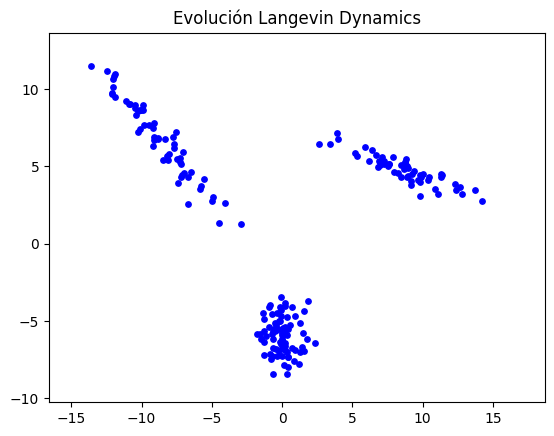

In [14]:
# Generar la data por langevin dynamics
data_ld, trayectoria = gm.langevin_dynamics()

In [15]:
# Código para graficar trayectorias de puntos
x = [point[0][0] for point in trayectoria]
y = [point[0][1] for point in trayectoria]

n_points = 200 # valor del largo del prior

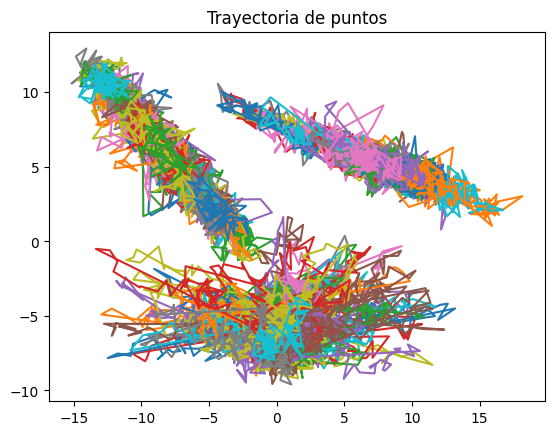

In [16]:
# Graficar trayectorias
for j in range(n_points):
  trayectoria_punto = []
  for i in range(j, len(trayectoria), n_points):
    trayectoria_punto.append([x[i], y[i]])
  trayectoria_punto = np.array(trayectoria_punto)
  plt.plot(trayectoria_punto[:,0], trayectoria_punto[:,1])
plt.title('Trayectoria de puntos')
plt.show()

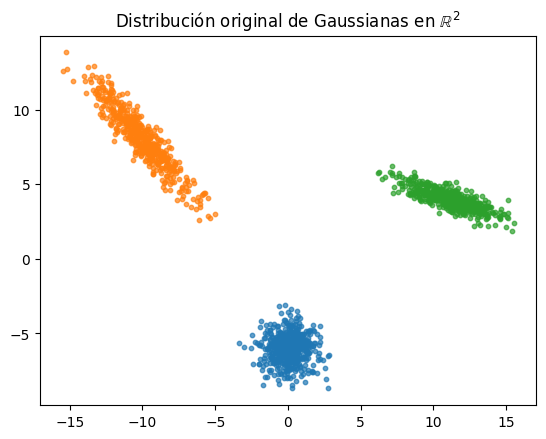

In [17]:
# Plotear las Gaussianas originales y comparar con el gif de abajo
for i in range(3):
  plt.scatter(lista_gaussianas[i][:, 0], lista_gaussianas[i][:, 1],
              alpha=0.7, label=f'Normal {i+1}', s=10)
plt.title('Distribución original de Gaussianas en $\mathbb{R}^2$')
plt.show()

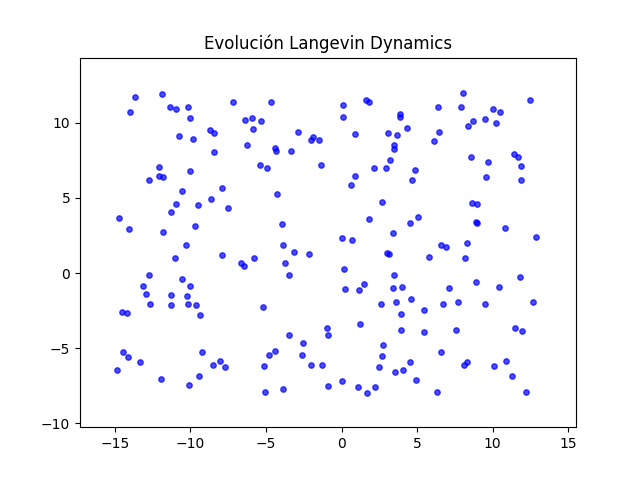

Acá se puede apreciar la evolución temporal que tiene el algoritmo de Langevin Dynamics donde al final se puede ver cómo los puntos se agrupan en la posición y con la forma que tienen las 3 distribuciones Gaussianas dadas al inicio. Esto se debe a que en cada tiempo $t$, se actualiza el vector $x$ de forma en que tenga una componente aleatoria $z_i$ y otra a la cual seguir la dirección $\nabla_x \log p(x)$, es decir, el score. Por otro lado, el valor de $\epsilon$ refleja un cierto ratio de "aprendizaje". Así, con $\epsilon\to 0$ y $T \to \infty$, la cadena converge a $p(x)$. (Notar que para la implementación bastó un $T$ relativamente pequeño y un $\epsilon = 0.05$).  

Este algoritmo tuvo como prior una distribución uniforme en el espacio, sin embargo, esto es solo para poder visualizar de mejor manera la trayectoria que realizan los puntos, pues se pudo haber elegido, por ejemplo, una normal como prior.  

Notar también que, a pesar de que se ve un buen resultado, el algoritmo no logra captar al completo la definición de los pesos $\alpha_k$, es decir, estos puntos se dirigen a las distribuciones originales sin importar que alguna tenga más o menos peso. Esto se piensa que solucionará el algoritmo de Annealed Langevin Dynamics.  

**Nota**: El gif es una de las mil iteraciones del algoritmo, no comparar con las últimas ejecuciones.

# P2

## (a)

Como la divergencia de Fisher es una comparación de distancias, es decir, es una métrica en $\ell^2$ entre el modelo basado en score y el score de la data. Esto dice que, si se minimiza la divergencia de Fisher, significa que el modelo está más cerca de los datos reales, obteniendo un mejor rendimiento y resultado final.  

El problema con para usar esta divergencia como función de costo es que requiere conocer con antelación la expresión del score de los datos, es decir, $\nabla_x \log p(x)$, lo cual es inviable. Para solucoinar esto se usan modelos que no usan esta expresión de forma directa.

## (b)

Con $\displaystyle q_{\sigma}(\tilde{x}|x) = \frac{1}{\sigma \sqrt{(2\pi)^d}} e^{-\frac{1}{2\sigma} (\tilde{x}-x)^T  (\tilde{x}-x)}$ nos queda lo siguiente:  

\begin{equation*}
  l(\theta; \sigma) = \frac{1}{2} \mathbb{E}_{q_{\sigma}(\tilde{x}|x)p(x)}\Bigg(\left\lVert
  s_{\theta}(\tilde{x}) - \nabla_{\tilde{x}} \log \frac{e^{-\frac{1}{2\sigma} (\tilde{x}-x)^T  (\tilde{x}-x)}}{\sigma \sqrt{(2\pi)^d}} \right\rVert_2^2\Bigg)
\end{equation*}  

\begin{equation*}
  ⟹
  l(\theta; \sigma) = \frac{1}{2} \mathbb{E}_{q_{\sigma}(\tilde{x}|x)p(x)}\Bigg(\left\lVert
  s_{\theta}(\tilde{x}) - \nabla_{\tilde{x}} \log \frac{e^{-\frac{1}{2\sigma} (\tilde{x}-x)^T  (\tilde{x}-x)}}{\sigma \sqrt{(2\pi)^d}} \right\rVert_2^2\Bigg)
  =
  \frac{1}{2} \mathbb{E}_{q_{\sigma}(\tilde{x}|x)p(x)}\Bigg(\left\lVert
  s_{\theta}(\tilde{x}) - \frac{1}{q_{\sigma}(\tilde{x}|x) \sigma \sqrt{(2\pi)^d}} \nabla_{\tilde{x}} e^{-\frac{1}{2\sigma} (\tilde{x}-x)^T  (\tilde{x}-x)} \right\rVert_2^2\Bigg)
  =
  \frac{1}{2} \mathbb{E}_{q_{\sigma}(\tilde{x}|x)p(x)}\Bigg(\left\lVert
  s_{\theta}(\tilde{x}) - \frac{1}{q_{\sigma}(\tilde{x}|x) \sigma \sqrt{(2\pi)^d}} e^{-\frac{1}{2\sigma} (\tilde{x}-x)^T  (\tilde{x}-x)} \cdot (\frac{-1}{\sigma}(\tilde{x}-x)) \right\rVert_2^2\Bigg)
\end{equation*}  
<br>
Con esto tenemos que,  
\begin{equation*}
  \mathcal{L}(\theta; \{\sigma_t\}_{t=1}^T) = \frac{1}{T} \sum_{t=1}^T \lambda(\sigma_t)l(\theta; \sigma_t)
  \\
  =
  \frac{1}{T} \sum_{t=1}^T \lambda(\sigma_t) \cdot \frac{1}{2} \mathbb{E}_{q_{\sigma}(\tilde{x}|x)p(x)}\Bigg(\left\lVert
  s_{\theta}(\tilde{x}) - \frac{1}{q_{\sigma_t}(\tilde{x}|x) \sigma \sqrt{(2\pi)^d}} e^{-\frac{1}{2\sigma_t} (\tilde{x}-x)^T  (\tilde{x}-x)} \cdot (\frac{-1}{\sigma_t}(\tilde{x}-x)) \right\rVert_2^2\Bigg) \\
  =
  \frac{1}{T} \sum_{t=1}^T \lambda(\sigma_t) \cdot \frac{1}{2} \mathbb{E}_{q_{\sigma}(\tilde{x}|x)p(x)}\Bigg(\left\lVert
  s_{\theta}(\tilde{x}) +  \frac{(\tilde{x}-x)}{\sigma_t}\right\rVert_2^2\Bigg)
\end{equation*}  

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
def get_timestep_embedding(timesteps, embedding_dim):
    """
    Embeddings posicionales sinusoidales
    Fuente: https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py
    """
    assert len(timesteps.size()) == 1

    half_dim = embedding_dim // 2
    emb = torch.arange(half_dim, dtype=torch.float32)
    emb = torch.exp(emb * (-math.log(10000) / (half_dim - 1)))
    emb = timesteps.view(-1, 1) * emb.view(1, -1)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1))

    assert emb.shape == (timesteps.size(0), embedding_dim)
    return emb

In [20]:
# Función que recibe un punto x y lo perturba según sigma por una normal
def perturbacion(x, sigma=5):
  if type(x) == np.ndarray:
    x = torch.from_numpy(x).float().to(device)
  x_perturbado = x + sigma*torch.randn_like(x)
  return x_perturbado

In [45]:
# Función que calcula el denoising score matching c/r a un sigma
def denoising_score_matching(x, model, t):
  sigma = lista_sigmas[t]
  x_perturbado = perturbacion(x, sigma=sigma)
  y = - 1 /(sigma**2) * (x_perturbado - x)
  scores = model(x_perturbado, sigma)
  loss = ((scores - y) ** 2).sum(dim=-1).mean(dim=0)/2
  return loss

In [50]:
# Función que calcula la loss c/r a todos los sigmas
def dsm_loss(x, model, lista_sigmas):
  T = len(lista_sigmas)
  sum = 0
  for t in range(T):
    sum += lista_sigmas[t]**2 * denoising_score_matching(x, model, t)
  return sum/T

## (c)

Según el [blog](https://yang-song.net/blog/2021/score/) de Yang Song, una secuencia adecuada en la práctica para elegir los ruidos $\sigma_t$ es una progresión de tipo geométrica, es decir, que tengan un paso o ratio $r$. Así,
se toma una secuencia $\sigma_1, \sigma_2, ..., \sigma_L$ tal que $\sigma_i = r\sigma_{i-1}$.  

La idea detrás de usar ruido para aprender el score el porque después queremos sampear de una distribución simple como es una gaussiana (o los datos con suficiente ruido) y así usar lo que aprendió la red (dennoising) para acercarnos más a la distribución original usando el score.

In [179]:
# Grilla
xy = np.mgrid[-15:15:1, -8:13:1].reshape(2, -1).T
print('largo grilla:', len(xy))

# Sigmas a utilizar
lista_sigmas = np.geomspace(1, 30, num=500)#[::-1]
print('sigmas:', lista_sigmas)

largo grilla: 630
sigmas: [ 1.          1.00683931  1.01372539  1.02065857  1.02763917  1.03466752
  1.04174393  1.04886873  1.05604227  1.06326487  1.07053687  1.0778586
  1.08523041  1.09265263  1.10012562  1.10764972  1.11522528  1.12285265
  1.13053219  1.13826424  1.14604919  1.15388737  1.16177916  1.16972493
  1.17772504  1.18577986  1.19388978  1.20205516  1.21027638  1.21855384
  1.2268879   1.23527897  1.24372742  1.25223366  1.26079807  1.26942106
  1.27810302  1.28684436  1.29564549  1.30450681  1.31342873  1.32241168
  1.33145606  1.3405623   1.34973082  1.35896205  1.36825641  1.37761433
  1.38703626  1.39652263  1.40607388  1.41569046  1.4253728   1.43512137
  1.4449366   1.45481897  1.46476893  1.47478694  1.48487346  1.49502897
  1.50525393  1.51554883  1.52591413  1.53635033  1.54685791  1.55743735
  1.56808914  1.57881379  1.58961178  1.60048363  1.61142983  1.62245089
  1.63354734  1.64471967  1.65596842  1.6672941   1.67869724  1.69017837
  1.70173802  1.71337673  

In [180]:
# Instanciar modelo
gm = GaussianMixture(lista_mu, lista_cov, lista_alpha)

# Generar samples
samples = gm.samples(1000)

In [347]:
# Perturbar los samples con distintos sigmas
porcentaje_10 = int(len(lista_sigmas) * 1/10)

samples_perturbados_1 = perturbacion(samples, sigma=lista_sigmas[0]).to('cpu')
samples_perturbados_2 = perturbacion(samples, sigma=lista_sigmas[porcentaje_10]).to('cpu')
samples_perturbados_3 = perturbacion(samples, sigma=lista_sigmas[2*porcentaje_10]).to('cpu')
samples_perturbados_4 = perturbacion(samples, sigma=lista_sigmas[3*porcentaje_10]).to('cpu')
samples_perturbados_5 = perturbacion(samples, sigma=lista_sigmas[5*porcentaje_10]).to('cpu')
samples_perturbados_6 = perturbacion(samples, sigma=lista_sigmas[7*porcentaje_10]).to('cpu')
samples_perturbados_7 = perturbacion(samples, sigma=lista_sigmas[9*porcentaje_10]).to('cpu')
samples_perturbados_8 = perturbacion(samples, sigma=lista_sigmas[-1]).to('cpu')

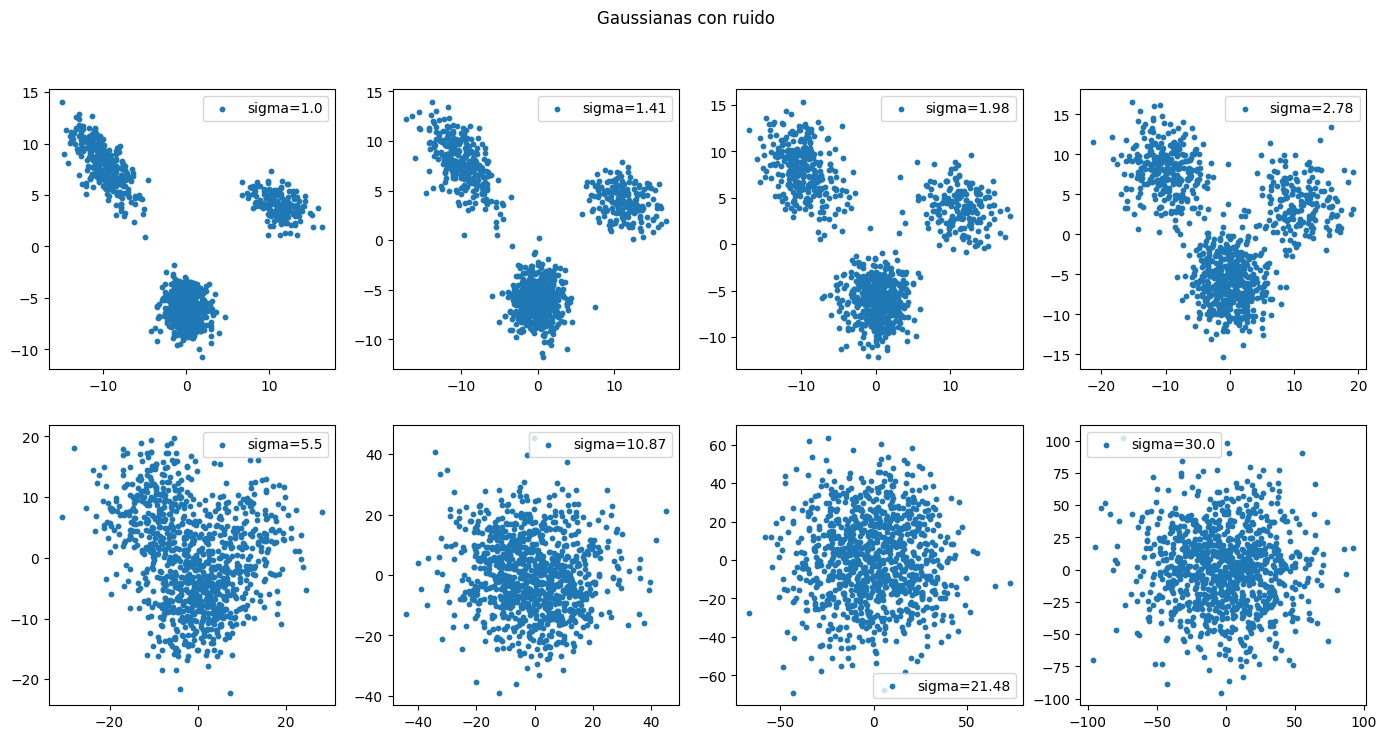

In [348]:
# Graficar los samples perturbados
fig, ax = plt.subplots(2, 4, figsize=(17,8))
fig.suptitle('Gaussianas con ruido')
ax[0][0].scatter(samples_perturbados_1[:,0], samples_perturbados_1[:,1],
              s=10, label=f'sigma={round(lista_sigmas[0],2)}')

ax[0][1].scatter(samples_perturbados_2[:,0], samples_perturbados_2[:,1],
              s=10, label=f'sigma={round(lista_sigmas[porcentaje_10],2)}')

ax[0][2].scatter(samples_perturbados_3[:,0], samples_perturbados_3[:,1],
              s=10, label=f'sigma={round(lista_sigmas[2*porcentaje_10],2)}')

ax[0][3].scatter(samples_perturbados_4[:,0], samples_perturbados_4[:,1],
              s=10, label=f'sigma={round(lista_sigmas[3*porcentaje_10],2)}')

ax[1][0].scatter(samples_perturbados_5[:,0], samples_perturbados_5[:,1],
              s=10, label=f'sigma={round(lista_sigmas[5*porcentaje_10],2)}')

ax[1][1].scatter(samples_perturbados_6[:,0], samples_perturbados_6[:,1],
              s=10, label=f'sigma={round(lista_sigmas[7*porcentaje_10],2)}')

ax[1][2].scatter(samples_perturbados_7[:,0], samples_perturbados_7[:,1],
              s=10, label=f'sigma={round(lista_sigmas[9*porcentaje_10],2)}')

ax[1][3].scatter(samples_perturbados_8[:,0], samples_perturbados_8[:,1],
              s=10, label=f'sigma={round(lista_sigmas[-1],2)}')

for i in range(len(ax[0])):
  ax[0][i].legend()
  ax[1][i].legend()
plt.show()

## (d)

In [159]:
class MLP(nn.Module):
  '''
  Multi Layer Perceptron
  '''
  def __init__(self, input_dim, output_dim, embedding_dim):
    super().__init__()
    self.embedding_dim=embedding_dim
    self.fc1 = nn.Linear(input_dim+embedding_dim, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, output_dim)

  def forward(self, x, sigma):
    temb = get_timestep_embedding(torch.tensor([sigma], dtype=torch.float32), self.embedding_dim)
    temb = temb.repeat(x.shape[0], 1)
    temb = temb.to(device)
    input = torch.cat((x, temb), dim=1)
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    input = input.to(torch.float32)
    #print(input.dtype)
    h_1 = F.relu(self.fc1(input))
    h_2 = F.relu(self.fc2(h_1))
    y_pred = self.fc3(h_2)
    return y_pred

In [235]:
class AnnealedLangevinDynamics(nn.Module):
  '''
  Clase de Annealed Langevin Dynamics
  '''
  def __init__(self, model, sigmas):
    super().__init__()
    self.sigmas = sigmas
    self.model = model

  # Generar samples según Annealed Langevin Dynamics
  @torch.no_grad()
  def sample(self, eps=0.0005, T=200): # eps=0.01
    x = np.random.uniform(low=xy[0], high=xy[-1], size=(1000,2))  #x_0
    #x = np.random.uniform(low=[-100,-100], high=[100,100], size=(200,2))  #x_0
    #x = torch.from_numpy(x).float().to(device)
    camera = Camera(plt.figure())
    plt.scatter(x[:, 0], x[:, 1], alpha=0.7, s=15, c='b')
    x = torch.from_numpy(x)
    x = x.to(device)
    camera.snap()
    #x = x.cpu().numpy()
    for i in range(len(self.sigmas)):
      alpha_i = eps * (self.sigmas[i]**2)/(self.sigmas[-1]**2)  #paso
      #print('sigma ', i)
      for t in range(1, T):
        z_t = torch.randn_like(x) * np.sqrt(alpha_i * 2)
        z_t.requires_grad = True
        x = x + alpha_i/2 * self.model(x, i) + np.sqrt(alpha_i)*z_t
      x_plot = x.detach().cpu().numpy()
      plt.scatter(x_plot[:, 0], x_plot[:, 1], s=10, c='b')
      camera.snap()
    # Generar gif
    #print('haciendo gif...')
    plt.xlim(-18, 18)
    plt.ylim(-10, 15)
    plt.title('Evolución Annealed Langevin Dynamics')
    anim = camera.animate(blit=True)
    anim.save('scatter_2.gif')
    return x

## (e)

In [161]:
# Definde model (MLP)
input_dim = 2
output_dim = 2
embedding_dim = 32

#model = MLP(input_dim, output_dim, timesteps)
model = MLP(input_dim, output_dim, embedding_dim)
model = model.to(device)

# Define optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [71]:
def train(model, iterator, lista_sigmas, optimizer):
  epoch_loss = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation
  model.train()

  #Training loop
  for (x,) in iterator:
    x = x.to(device)  #Data
    optimizer.zero_grad()  #Clean gradients
    loss = dsm_loss(x, model, lista_sigmas)  #Compute the loss
    loss.backward()  #Compute gradients
    optimizer.step()  #Apply update rules
    epoch_loss += loss.item()

  return epoch_loss / len(iterator)


def evaluate(model, iterator, lista_sigmas):
  epoch_loss = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for
  #training (dropout for instance)
  model.eval()

  with torch.no_grad(): #disable the autograd engine (save computation and memory)
    for (x,) in iterator:
      x = x.to(device)  #Data
      loss = dsm_loss(x, model, lista_sigmas)  #Compute the loss
      epoch_loss += loss.item()

  return epoch_loss / len(iterator)


# Custom function to print every epoch and time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [41]:
# Train, val and test sets
n = 4 #len(lista_sigmas)
X_train = torch.tensor(gm.samples(100*n), requires_grad=True)
X_val = torch.tensor(gm.samples(2*n), requires_grad=True)
X_test = torch.tensor(gm.samples(5*n), requires_grad=True)

train_dataset = data.TensorDataset(X_train)
val_dataset = data.TensorDataset(X_val)
test_dataset = data.TensorDataset(X_test)

BATCH_SIZE = 32

train_iterator = data.DataLoader(train_dataset, shuffle=False, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [162]:
#Let's perform the training

EPOCHS = 30

best_valid_loss = float('inf')

for epoch in range(EPOCHS):

  start_time = time.time()

  #Train + validation cycles
  train_loss = train(model, train_iterator, lista_sigmas[::-1], optimizer)
  valid_loss = evaluate(model, valid_iterator,lista_sigmas[::-1])

  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f}')
  print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 89.354
	 Val. Loss: 55.520
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 55.044
	 Val. Loss: 42.362
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 44.711
	 Val. Loss: 35.832
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 38.235
	 Val. Loss: 28.156
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 34.699
	 Val. Loss: 24.089
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 34.932
	 Val. Loss: 27.329
Epoch: 07 | Epoch Time: 0m 8s
	Train Loss: 34.121
	 Val. Loss: 24.804
Epoch: 08 | Epoch Time: 0m 8s
	Train Loss: 32.718
	 Val. Loss: 22.649
Epoch: 09 | Epoch Time: 0m 8s
	Train Loss: 31.515
	 Val. Loss: 19.711
Epoch: 10 | Epoch Time: 0m 7s
	Train Loss: 31.798
	 Val. Loss: 20.822
Epoch: 11 | Epoch Time: 0m 8s
	Train Loss: 30.615
	 Val. Loss: 19.151
Epoch: 12 | Epoch Time: 0m 8s
	Train Loss: 30.460
	 Val. Loss: 19.284
Epoch: 13 | Epoch Time: 0m 7s
	Train Loss: 30.482
	 Val. Loss: 19.026
Epoch: 14 | Epoch Time: 0m 8s
	Train Loss: 30.145
	 Val. Loss: 18.356
Epoch: 15 | Epoch Ti

In [163]:
#Load the best model
model.load_state_dict(torch.load('saved-model.pt'))

test_loss = evaluate(model, test_iterator, lista_sigmas)
print(f'Test Loss: {test_loss:.3f}')

Test Loss: 4.325


In [233]:
lista_sigmas_test = np.geomspace(1, 30, num=15)[::-1]
lista_sigmas_test

array([30.        , 23.52949432, 18.45457009, 14.47422341, 11.35237191,
        8.90385235,  6.98343811,  5.47722558,  4.29587827,  3.36932811,
        2.64261955,  2.07265006,  1.62561359,  1.27499553,  1.        ])

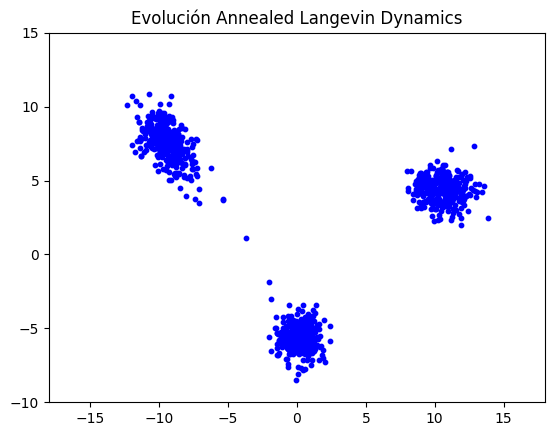

In [245]:
# Initialize Annealed Langevin Dynamic class
ald = AnnealedLangevinDynamics(model, lista_sigmas_test)

# Generate samples
ald_samples = ald.sample(eps=0.0002, T=100)

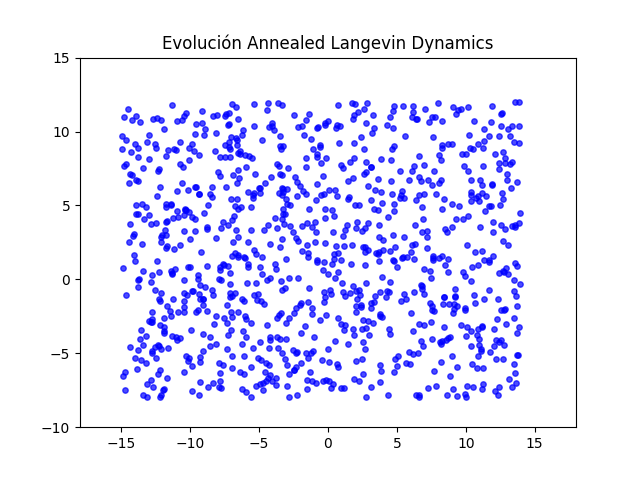

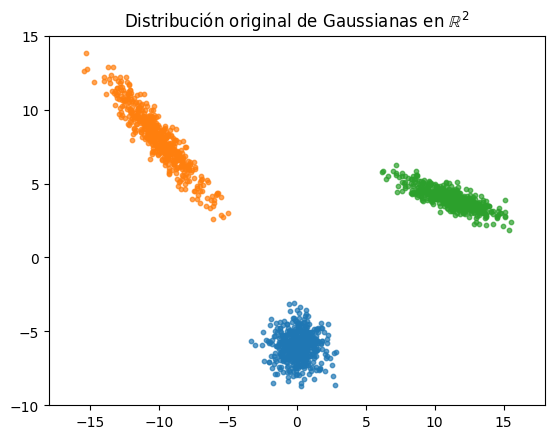

In [214]:
# Plotear las Gaussianas originales y comparar con el gif de abajo
for i in range(3):
  plt.scatter(lista_gaussianas[i][:, 0], lista_gaussianas[i][:, 1],
              alpha=0.7, label=f'Normal {i+1}', s=10)
plt.title('Distribución original de Gaussianas en $\mathbb{R}^2$')
# Mismos límites que el gif
plt.xlim(-18, 18)
plt.ylim(-10, 15)
plt.show()

Como se puede ver en las figuras de arriba, se tiene la evolución en el tiempo de los puntos del espacio con el algoritmo de Annealed Langevin Dynamics junto con la distribución original (con algunos puntos sampleados) para poder comparar el resultad.  

Se puede notar que la aplicación del algoritmo y de la red neuronal que aprende el score es correcta, sin embargo, se sospecha que puede necesitar algún cambio ya sea en lo parámetros de la red o en Annealed Langevin pues no logra captar la forma con precisión. Esto también se puede deber al poco rango de épocas que fue seleccionado para su entrenamiento debido al tiempo y a la restricción de poder computacional. Sin embargo, se logra una distribución muy parecida con los centros de gravedad de las distribuciones adecuados.

# P3

## (a)

```python
class SDE(torch.nn.Module):

def __init__(self, f, g):
  super().__init__()
  self.f = f
  self.g = g

# Drift de la ecuación reversa
def reverse_drift(self, x, t, score):
  return self.f(x,t) - (self.g(t)**2 * score)
```

## (b)

El proceso de Ornstein–Uhlenbeck es un proceso de Markov Gaussiano estacionario definido como $dx_t = -\theta (\mu-x_t)dt + \sigma dW_t$. Es decir, es un proceso estocástico con pérdida de memoria, cada colección finita es una normal multivariada y además es temporalmente homogénea (se ve parecido independientemente si movemos el intervalo de tiempo a analizar).  

Alguna de las propiedades de este proceso son las siguientes:


*   Con $x_0$ valor fijo, $\displaystyle \mathbb{E}(x_t|x_0) = x_0e^{-\theta t} + \mu(1-e^{-\theta t})$
*   $\displaystyle \text{cov}(x_s,x_t) = \frac{\sigma^2}{2\theta} \big(e^{-\theta |t-s| - e^{-\theta (t+s)}}\big)$

Mientras que para el proceso no condicionado la esperanza de $x_t$ es $\mu$ y la covarianza de $x_s$ y $x_t$ es $\frac{\sigma^2}{2\theta} e^{-\theta |t-s|}$  

Por otro lado, su solución (usando cálculo de Itô) es:
\begin{equation*}
  x_t = x_0e^{-\theta t} + \mu(1-e^{-\theta t}) + \frac{\sigma}{\sqrt{2 \theta}} W_{1-e^{-2\theta t}}
\end{equation*}

## (c)

In [319]:
class  OU_SDE():
  '''
  Ornstein–Uhlenbeck SDE class
  '''
  def sde(x, dt):
    dx = -x*dt/2 + np.random.normal(0, 1)
    return dx


  # Drift de la ecuación reversa
  def reverse_drift(self, x, score):
    return -x/2 - score


  def Solucion_Analitica(self, T, N, x_0):
    dt = T / N
    x = [x_0]
    t = np.arange(0, T, dt)
    for i in range(len(t)):
      z_t = np.random.normal(0, 1)
      x.append(np.exp(-t[i])*x_0 + np.sqrt(1-np.exp(-2*t[i]))*z_t)
    return x


  # Método discretización sde
  def Euler_Maruyama(self, T, N, x_0):
    dt = T / N
    x = [x_0]
    t = np.arange(0, T, dt)
    for i in range(len(t)):
      z_t = np.random.normal(0, dt)
      x.append(x[i] - (1/2)*x[i]*dt + z_t)
    return x


  # Método discretización sde reversa
  def Reverse_Euler_Maruyama(self, scores, T, N, x_0):
    dt = T / N
    x = [x_0]
    t = np.arange(0, T, dt)
    for i in range(len(t)-1):
      reverse_drift = self.reverse_drift(x[i], scores[i])
      z_t = np.random.normal(0, dt)
      x.append(x[i] + reverse_drift*dt + z_t)
    return x

## (d)

In [316]:
class SDE(torch.nn.Module):
  '''
  SDE General class
  '''
  def __init__(self, f, g):
    super().__init__()
    self.f = f
    self.g = g


  # Drift de la ecuación reversa
  def reverse_drift(self, x, t, score):
    return self.f(x,t) - (self.g(t)**2 * score)


  # Método discretización sde
  def Euler_Maruyama(self, T, N, x_0):
    dt = T / N
    x = [x_0]
    t = np.arange(0, T, dt)
    for i in range(len(t)):
      z_t = np.random.normal(0, dt)
      x.append(x[i] + self.f(x[i], t[i])*dt + self.g(t[i])*z_t)
    return x

In [248]:
# Parámetros
T=10
N=100
x_0 = np.random.uniform()
print('x_0:', x_0)

# OU class
ou_sde = OU_SDE()
sol_analitica = ou_sde.Solucion_Analitica(T, N, x_0)
sol_discreta = ou_sde.Euler_Maruyama(T, N, x_0)

x_0: 0.2555844596454827


In [249]:
# OU sde
f = lambda x, t: -1/2 * x
g = lambda x: 1

# General sde class
sde = SDE(f, g)

sol_discreta_2 = sde.Euler_Maruyama(T, N, x_0)

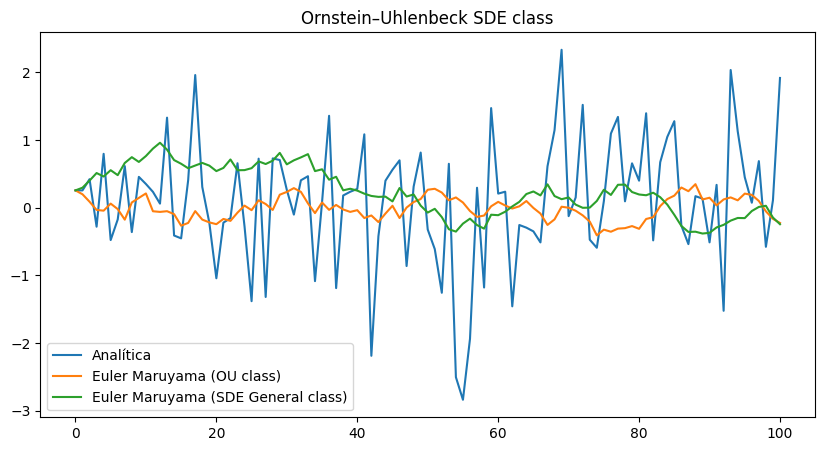

In [250]:
# Graficar solución discreta con analítica
plt.figure(figsize=(10, 5))
plt.plot(sol_analitica, label='Analítica')
plt.plot(sol_discreta, label='Euler Maruyama (OU class)')
plt.plot(sol_discreta_2, label='Euler Maruyama (SDE General class)')
plt.title('Ornstein–Uhlenbeck SDE class')
plt.legend()
plt.show()

En este gráfico se puede ver la solución teórica de la sde de Ornstein–Uhlenbeck junto con su solución discretizada según el método de Euler-Maruyama.  
En el gráfico anterior se pueden ver 2 soluciones discretizadas pues se pusieron a prueba las 2 clases creadas. Una que modela una sde general y otra la ecuación específica de Ornstein–Uhlenbeck. Notar que ambas clases emplean el mismo método de solución discreta, sin embargo poseen ciertas diferencias pues este método recae en cierta aleatoriedad al calcular el valor de $z_t \sim \mathcal{N}(0,1)$.

## (e)

In [320]:
# Parámetros
T=10
N=100
x_0 = np.random.uniform(low=xy[0], high=xy[-1], size=(200,2))
print('x_0:', x_0)

# OU class
ou_sde = OU_SDE()

x_0: [[-10.20673335  10.17413091]
 [-13.8506753    1.1566424 ]
 [ 13.30476661  -6.13857584]
 [  2.09004711   7.25490913]
 [  0.32579328   9.23488758]
 [ -1.25302272   3.16489066]
 [  8.29362086   1.67125882]
 [  9.63938702   2.21829211]
 [  1.90814223   1.93080812]
 [-10.68659856  -4.15154599]
 [-14.64697326   7.34072994]
 [ -9.94653568  -3.51528522]
 [  3.47732184   8.66530364]
 [ -1.46339013  -7.11332259]
 [ -7.04278965   7.6499782 ]
 [-10.20900478   5.39448619]
 [-11.51328164   3.93688106]
 [  2.07444885   5.72207136]
 [  9.95701708   5.59270169]
 [  5.74754742   5.41860699]
 [  4.04887999   7.42753523]
 [  5.50722239  -2.98877943]
 [-10.8921222   -7.0495821 ]
 [  8.17775331  11.127085  ]
 [  8.56575718   5.63180652]
 [ 10.89638181   5.67350798]
 [  4.37243897  -0.52929529]
 [ -8.4723935   -6.6862392 ]
 [ 13.69676447  -7.52920777]
 [  1.89980606   9.8198183 ]
 [-11.89574311   5.6208281 ]
 [  9.89286075  -2.68175371]
 [ -6.94084329   3.2682446 ]
 [-12.89372494   3.29708664]
 [-10.785